In [1]:
from sklearn.datasets import make_moons
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os , sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from core.optimization import NSGAConfig, run_nsga, run_moc_nsga
from core.cf_problem import make_cf_problem
from core.data import DataGenerator, DatasetsDG
from core.models import SimpleNN,EnsembleModel
from matplotlib import pyplot as plt
from utils import plot_proba, plot_uncertainty_heatmap, plot_cf_3d

In [2]:
import importlib
import core.optimization
import core.cf_problem

importlib.reload(core.optimization)
importlib.reload(core.cf_problem)

<module 'core.cf_problem' from 'e:\\Thieses mit Thies\\uamocf\\core\\cf_problem.py'>

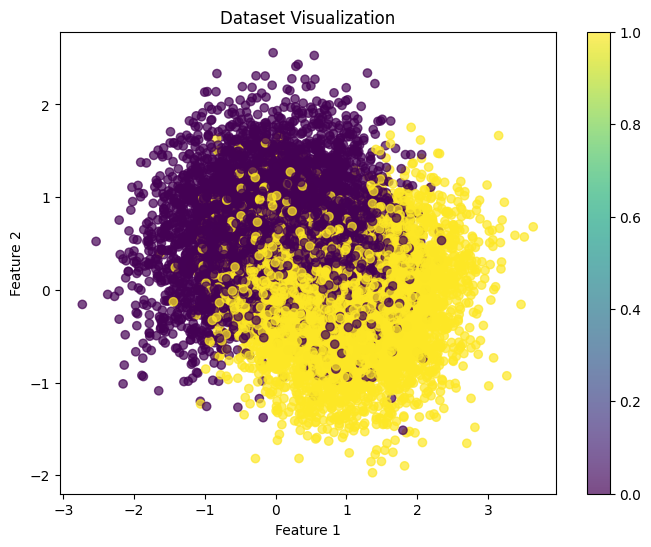

In [3]:
ds=make_moons(n_samples=10000, noise=0.5, random_state=42)

tds = TensorDataset(torch.tensor(ds[0], dtype=torch.float32), torch.tensor(ds[1], dtype=torch.long))
dg=DatasetsDG(tds, num_classes=2)
dg.plot()

In [4]:
models = [SimpleNN(input_dim=2, hidden_dim=14, output_dim=2, depth=3) for _ in range(5)]
ensemble_model = EnsembleModel(models=models)


# train each model in the ensemble
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)
epochs = 150
val_data = dg.sample(500, seed=123)
for model in ensemble_model.models:
    seed = 42 + hash(model) % 1000  # Simple way to get different seeds
    samples = dg.sample(400, seed=seed)
    _tds= TensorDataset(samples[0].to(device), samples[1].to(device))
    DL=DataLoader(_tds, batch_size=256, shuffle=True)
    model.train()
    bar = tqdm(range(epochs), desc="Training Model", colour="blue", unit="epoch")
    running_loss = 0.0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in bar:
        for inputs, labels in DL:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        bar.set_postfix({"loss": running_loss / (epoch + 1)})
    
    model.eval()
    with torch.no_grad():
        val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
        val_outputs = model(val_inputs)
        _, val_preds = torch.max(val_outputs, 1)
        _, val_labels_idx = torch.max(val_labels, 1)
        val_accuracy = (val_preds == val_labels_idx).float().mean().item()
        print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Finished Training Model")

Training Model: 100%|██████████| 150/150 [00:02<00:00, 50.07epoch/s, loss=0.94]  


Validation Accuracy: 80.20%
Finished Training Model


Training Model: 100%|██████████| 150/150 [00:01<00:00, 120.15epoch/s, loss=0.933]


Validation Accuracy: 80.80%
Finished Training Model


Training Model: 100%|██████████| 150/150 [00:01<00:00, 113.39epoch/s, loss=0.92] 


Validation Accuracy: 79.80%
Finished Training Model


Training Model: 100%|██████████| 150/150 [00:01<00:00, 115.33epoch/s, loss=0.955]


Validation Accuracy: 80.40%
Finished Training Model


Training Model: 100%|██████████| 150/150 [00:01<00:00, 117.83epoch/s, loss=0.975]

Validation Accuracy: 79.40%
Finished Training Model


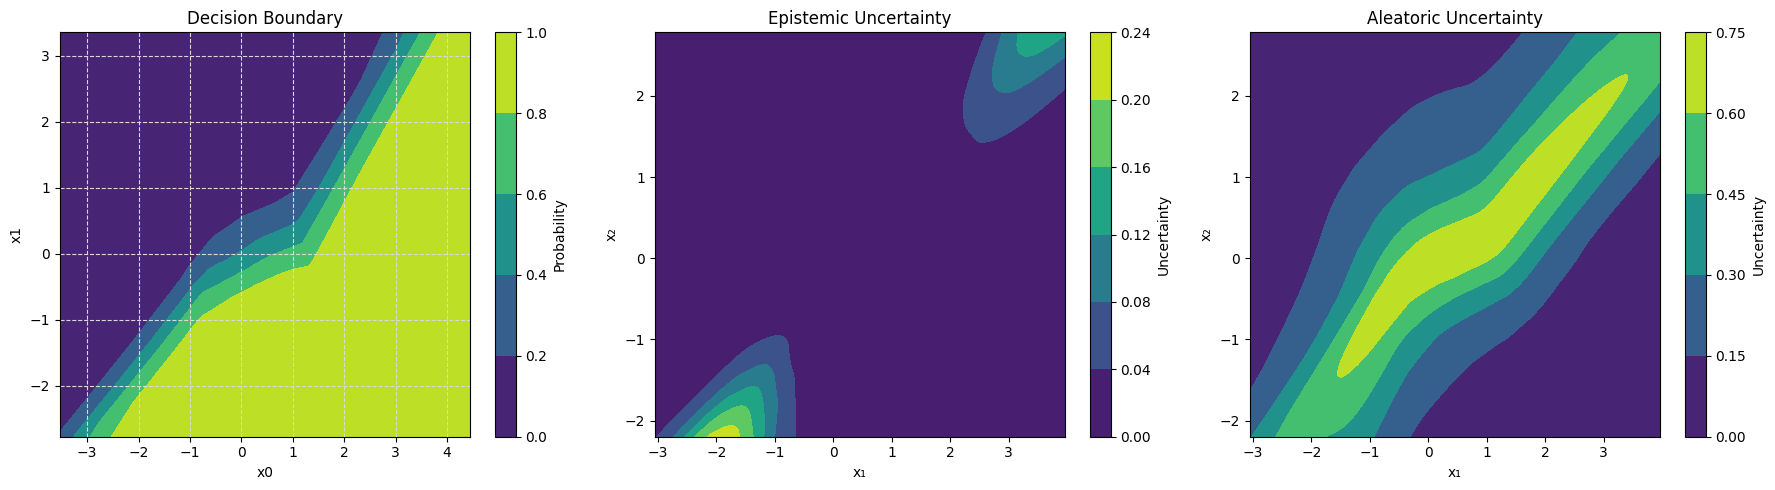

In [5]:
# plot decision boundary


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_proba(ensemble_model.models[0], ds[0], levels=5, ax=axes[0])
axes[0].set_title("Decision Boundary")

plot_uncertainty_heatmap(ensemble_model, ds[0], uncertainty_type="epistemic", device=device, levels=5, ax=axes[1])
axes[1].set_title("Epistemic Uncertainty")

plot_uncertainty_heatmap(ensemble_model, ds[0], uncertainty_type="aleatoric", device=device, levels=5, ax=axes[2])
axes[2].set_title("Aleatoric Uncertainty")

plt.tight_layout()
plt.show()

In [6]:
x_factual = torch.tensor([[2, -1]], dtype=torch.float32)
y_target = torch.tensor([0], dtype=torch.long)
X_obs = dg.sample(1000, seed=456)[0]
if isinstance(X_obs, torch.Tensor):
    X_obs = X_obs.clone().detach().float()
else:
    X_obs = torch.tensor(X_obs, dtype=torch.float32)

NSGA2_config = NSGAConfig(
    pop_size=150,
    min_gen=250,        
    max_gen=5950,
    use_conditional_mutator=True,
    conditional_mutator_prob=0.7,
    use_reset_operator=True,
    reset_prob=0.05,
)

# ============ VERSION 1: With Uncertainty (EU/AU) ============
print("=" * 50)
print("Running VERSION 1: With Epistemic & Aleatoric Uncertainty")
print("Objectives: [Validity, EU, Sparsity, -AU]")
print("=" * 50)
problem_uncertainty = make_cf_problem(
    ensemble_model.models[0], x_factual, y_target, X_obs, 
    device=device, 
    ensemble=ensemble_model  # Enables EU/AU objectives
)
results_uncertainty = run_nsga(problem_uncertainty, NSGA2_config, X_obs=X_obs.numpy(), x_factual=x_factual.numpy())

# ============ VERSION 2: Simple (Similarity/Plausibility) ============
print("\n" + "=" * 50)
print("Running VERSION 2: Simple (Similarity & Plausibility)")
print("Objectives: [Validity, Similarity, Sparsity, Plausibility]")
print("=" * 50)
problem_simple = make_cf_problem(
    ensemble_model.models[0], x_factual, y_target, X_obs, 
    device=device, 
    ensemble=None  # No ensemble = uses Similarity/Plausibility objectives
)
results_simple = run_nsga(problem_simple, NSGA2_config, X_obs=X_obs.numpy(), x_factual=x_factual.numpy())

print("\n✓ Both optimizations completed!")

Running VERSION 1: With Epistemic & Aleatoric Uncertainty
Objectives: [Validity, EU, Sparsity, -AU]
Gen    1 | Valid CFs (pop):  66 | Pareto front:  48 | Best P(target): 0.994 | Mean Sparsity: 1.979
Gen   10 | Valid CFs (pop): 124 | Pareto front: 150 | Best P(target): 0.993 | Mean Sparsity: 1.773
Gen   20 | Valid CFs (pop): 128 | Pareto front: 150 | Best P(target): 0.994 | Mean Sparsity: 1.787
Gen   30 | Valid CFs (pop): 132 | Pareto front: 150 | Best P(target): 0.995 | Mean Sparsity: 1.800
Gen   40 | Valid CFs (pop): 124 | Pareto front: 150 | Best P(target): 0.994 | Mean Sparsity: 1.793
Gen   50 | Valid CFs (pop): 129 | Pareto front: 150 | Best P(target): 0.994 | Mean Sparsity: 1.807
Gen   60 | Valid CFs (pop): 132 | Pareto front: 150 | Best P(target): 0.994 | Mean Sparsity: 1.787
Gen   70 | Valid CFs (pop): 130 | Pareto front: 150 | Best P(target): 0.994 | Mean Sparsity: 1.807
Gen   80 | Valid CFs (pop): 127 | Pareto front: 150 | Best P(target): 0.995 | Mean Sparsity: 1.767
Gen   90 

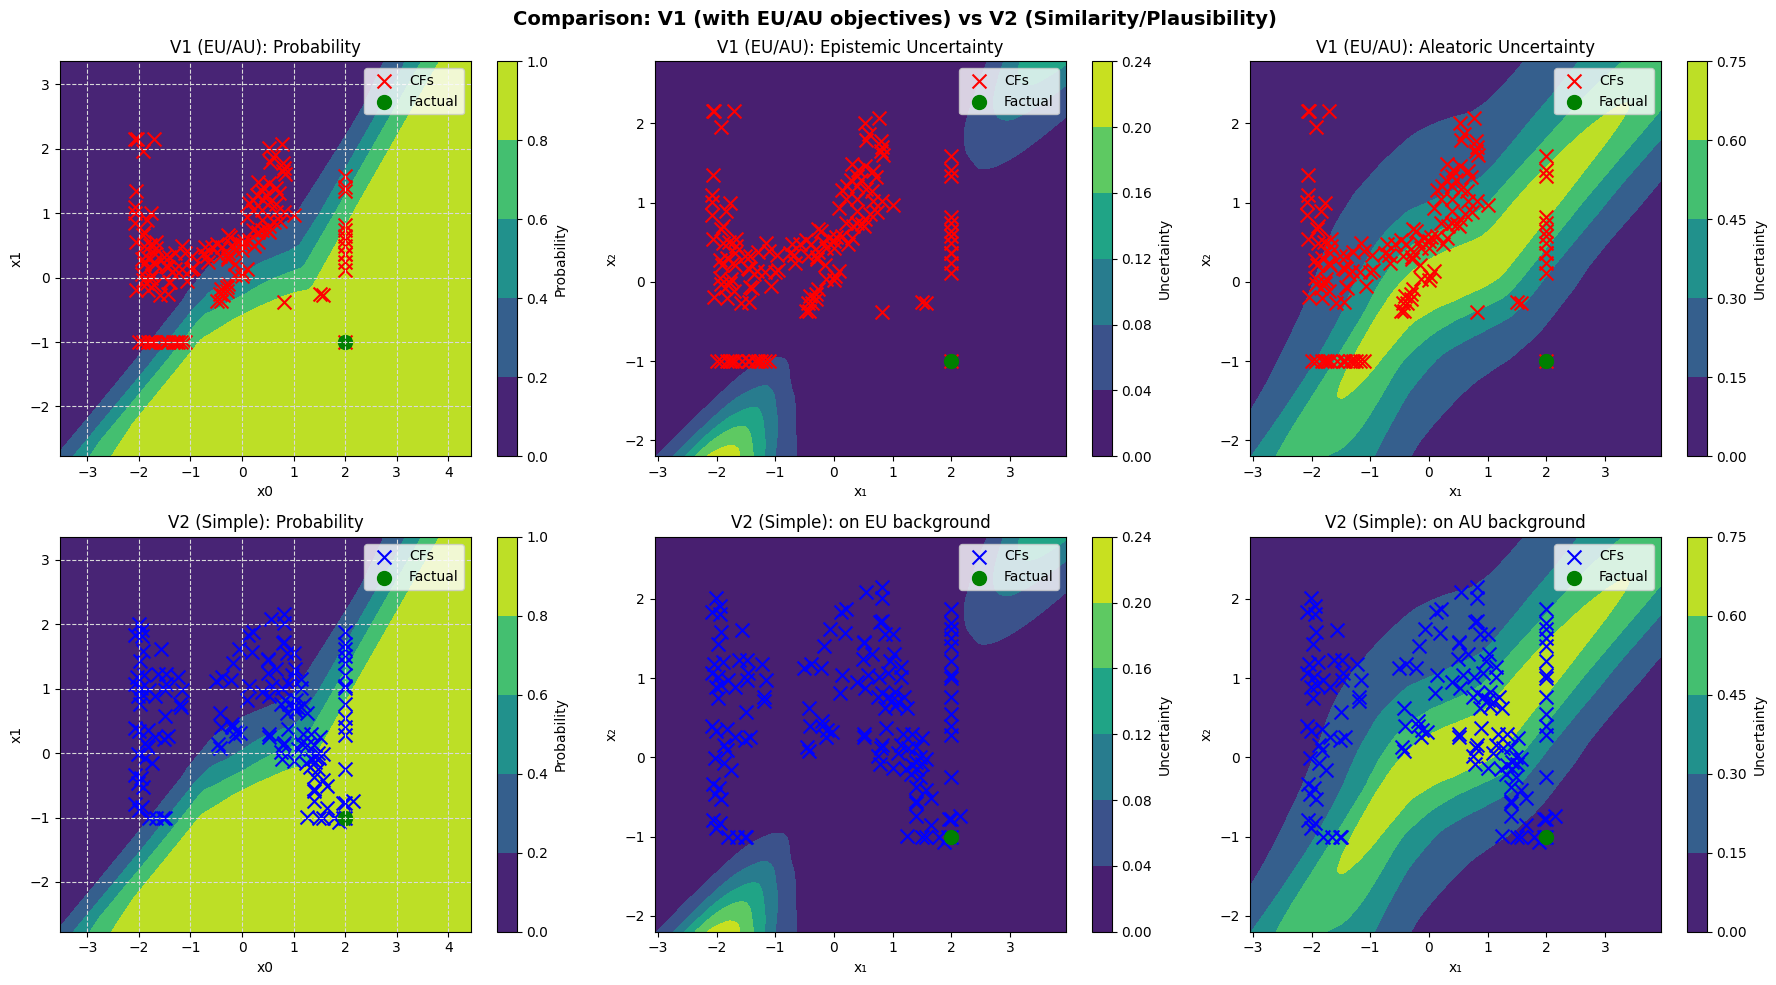

In [7]:
# Compare both versions in 2D feature space
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

cf_uncertainty = torch.tensor(results_uncertainty.X, dtype=torch.float32).cpu().numpy()
cf_simple = torch.tensor(results_simple.X, dtype=torch.float32).cpu().numpy()

# ============ ROW 1: VERSION 1 - With Uncertainty (EU/AU) ============
# 1. Probability background
plot_proba(ensemble_model.models[0], ds[0], levels=5, ax=axes[0, 0])
axes[0, 0].scatter(cf_uncertainty[:, 0], cf_uncertainty[:, 1], color='red', marker='x', s=100, label='CFs')
axes[0, 0].scatter(x_factual[0, 0].item(), x_factual[0, 1].item(), color='green', marker='o', s=100, label='Factual')
axes[0, 0].set_title("V1 (EU/AU): Probability")
axes[0, 0].legend()

# 2. Epistemic Uncertainty background
plot_uncertainty_heatmap(ensemble_model, ds[0], device=device, uncertainty_type="epistemic", levels=5, ax=axes[0, 1])
axes[0, 1].scatter(cf_uncertainty[:, 0], cf_uncertainty[:, 1], color='red', marker='x', s=100, label='CFs')
axes[0, 1].scatter(x_factual[0, 0].item(), x_factual[0, 1].item(), color='green', marker='o', s=100, label='Factual')
axes[0, 1].set_title("V1 (EU/AU): Epistemic Uncertainty")
axes[0, 1].legend()

# 3. Aleatoric Uncertainty background
plot_uncertainty_heatmap(ensemble_model, ds[0], device=device, uncertainty_type="aleatoric", levels=5, ax=axes[0, 2])
axes[0, 2].scatter(cf_uncertainty[:, 0], cf_uncertainty[:, 1], color='red', marker='x', s=100, label='CFs')
axes[0, 2].scatter(x_factual[0, 0].item(), x_factual[0, 1].item(), color='green', marker='o', s=100, label='Factual')
axes[0, 2].set_title("V1 (EU/AU): Aleatoric Uncertainty")
axes[0, 2].legend()

# ============ ROW 2: VERSION 2 - Simple (Similarity/Plausibility) ============
# 1. Probability background
plot_proba(ensemble_model.models[0], ds[0], levels=5, ax=axes[1, 0])
axes[1, 0].scatter(cf_simple[:, 0], cf_simple[:, 1], color='blue', marker='x', s=100, label='CFs')
axes[1, 0].scatter(x_factual[0, 0].item(), x_factual[0, 1].item(), color='green', marker='o', s=100, label='Factual')
axes[1, 0].set_title("V2 (Simple): Probability")
axes[1, 0].legend()

# 2. Epistemic Uncertainty background (for comparison)
plot_uncertainty_heatmap(ensemble_model, ds[0], device=device, uncertainty_type="epistemic", levels=5, ax=axes[1, 1])
axes[1, 1].scatter(cf_simple[:, 0], cf_simple[:, 1], color='blue', marker='x', s=100, label='CFs')
axes[1, 1].scatter(x_factual[0, 0].item(), x_factual[0, 1].item(), color='green', marker='o', s=100, label='Factual')
axes[1, 1].set_title("V2 (Simple): on EU background")
axes[1, 1].legend()

# 3. Aleatoric Uncertainty background (for comparison)
plot_uncertainty_heatmap(ensemble_model, ds[0], device=device, uncertainty_type="aleatoric", levels=5, ax=axes[1, 2])
axes[1, 2].scatter(cf_simple[:, 0], cf_simple[:, 1], color='blue', marker='x', s=100, label='CFs')
axes[1, 2].scatter(x_factual[0, 0].item(), x_factual[0, 1].item(), color='green', marker='o', s=100, label='Factual')
axes[1, 2].set_title("V2 (Simple): on AU background")
axes[1, 2].legend()

plt.suptitle("Comparison: V1 (with EU/AU objectives) vs V2 (Similarity/Plausibility)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
import importlib
import utils
importlib.reload(utils)
from utils import plot_cf_3d

# Convert tensors to numpy arrays for the plot
x_factual_np = x_factual.cpu().numpy() if isinstance(x_factual, torch.Tensor) else x_factual
context_data = dg.sample(10000, seed=789)[0]
context_np = context_data.cpu().numpy() if isinstance(context_data, torch.Tensor) else context_data

# ============ 3D Objective Space: VERSION 1 (EU/AU) ============
print("=" * 50)
print("3D Objective Space: VERSION 1 (with EU/AU)")
print("Axes: EU (x), Validity (y), AU (z - reversed)")
print("=" * 50)
plot_cf_3d(results=results_uncertainty, x_factual=x_factual_np, context=context_np)

3D Objective Space: VERSION 1 (with EU/AU)
Axes: EU (x), Validity (y), AU (z - reversed)


In [9]:
# ============ 3D Objective Space: VERSION 2 (Simple) ============
print("=" * 50)
print("3D Objective Space: VERSION 2 (Similarity/Plausibility)")
print("Axes: Similarity (x), Validity (y), Plausibility (z)")
print("=" * 50)
plot_cf_3d(results=results_simple, x_factual=x_factual_np, context=context_np)

3D Objective Space: VERSION 2 (Similarity/Plausibility)
Axes: Similarity (x), Validity (y), Plausibility (z)


In [10]:
# ============ Summary Comparison ============
print("=" * 60)
print("SUMMARY: Objective Values Comparison")
print("=" * 60)

print("\n--- VERSION 1: With Uncertainty (EU/AU) ---")
print("Objectives: [Validity, Epistemic U., Sparsity, -Aleatoric U.]")
print(f"Number of Pareto solutions: {len(results_uncertainty.X)}")
print(f"Validity range: [{results_uncertainty.F[:,0].min():.4f}, {results_uncertainty.F[:,0].max():.4f}]")
print(f"Epistemic U. range: [{results_uncertainty.F[:,1].min():.4f}, {results_uncertainty.F[:,1].max():.4f}]")
print(f"Sparsity range: [{results_uncertainty.F[:,2].min():.4f}, {results_uncertainty.F[:,2].max():.4f}]")
print(f"-AU range: [{results_uncertainty.F[:,3].min():.4f}, {results_uncertainty.F[:,3].max():.4f}]")
print(f" → AU (positive): [{-results_uncertainty.F[:,3].max():.4f}, {-results_uncertainty.F[:,3].min():.4f}]")

print("\n--- VERSION 2: Simple (Similarity/Plausibility) ---")
print("Objectives: [Validity, Similarity, Sparsity, Plausibility]")
print(f"Number of Pareto solutions: {len(results_simple.X)}")
print(f"Validity range: [{results_simple.F[:,0].min():.4f}, {results_simple.F[:,0].max():.4f}]")
print(f"Similarity range: [{results_simple.F[:,1].min():.4f}, {results_simple.F[:,1].max():.4f}]")
print(f"Sparsity range: [{results_simple.F[:,2].min():.4f}, {results_simple.F[:,2].max():.4f}]")
print(f"Plausibility range: [{results_simple.F[:,3].min():.4f}, {results_simple.F[:,3].max():.4f}]")

SUMMARY: Objective Values Comparison

--- VERSION 1: With Uncertainty (EU/AU) ---
Objectives: [Validity, Epistemic U., Sparsity, -Aleatoric U.]
Number of Pareto solutions: 150
Validity range: [0.0048, 0.9890]
Epistemic U. range: [0.0001, 0.0426]
Sparsity range: [0.0000, 2.0000]
-AU range: [-0.6926, -0.0487]
 → AU (positive): [0.0487, 0.6926]

--- VERSION 2: Simple (Similarity/Plausibility) ---
Objectives: [Validity, Similarity, Sparsity, Plausibility]
Number of Pareto solutions: 150
Validity range: [0.0058, 0.9890]
Similarity range: [0.0000, 0.7714]
Sparsity range: [0.0000, 2.0000]
Plausibility range: [0.0058, 0.1270]
